In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib auto
from prophet import Prophet

Using matplotlib backend: <object object at 0x0000023723441A10>


In [4]:
import pandas as pd
df = pd.read_csv('Crime_Data_from_2010_to_2019.csv')
# df = df.groupby('DATE OCC').count()['Crm Cd'].to_frame()
# df = df[df['DATE OCC'] > '06-30-2010']
df['Date'] = pd.to_datetime(df['DATE OCC']).dt.date
df

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON,Date
0,1307355,02/20/2010 12:00:00 AM,02/20/2010 12:00:00 AM,1350,13,Newton,1385,2,900,VIOLATION OF COURT ORDER,...,Adult Arrest,900.0,NaN,NaN,NaN,300 E GAGE AV,NaN,33.9825,-118.2695,2010-02-20
1,11401303,09/13/2010 12:00:00 AM,09/12/2010 12:00:00 AM,45,14,Pacific,1485,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",...,Invest Cont,740.0,NaN,NaN,NaN,SEPULVEDA BL,MANCHESTER AV,33.9599,-118.3962,2010-09-12
2,70309629,08/09/2010 12:00:00 AM,08/09/2010 12:00:00 AM,1515,13,Newton,1324,2,946,OTHER MISCELLANEOUS CRIME,...,Invest Cont,946.0,NaN,NaN,NaN,1300 E 21ST ST,NaN,34.0224,-118.2524,2010-08-09
3,90631215,01/05/2010 12:00:00 AM,01/05/2010 12:00:00 AM,150,6,Hollywood,646,2,900,VIOLATION OF COURT ORDER,...,Invest Cont,900.0,998.0,NaN,NaN,CAHUENGA BL,HOLLYWOOD BL,34.1016,-118.3295,2010-01-05
4,100100501,01/03/2010 12:00:00 AM,01/02/2010 12:00:00 AM,2100,1,Central,176,1,122,"RAPE, ATTEMPTED",...,Invest Cont,122.0,NaN,NaN,NaN,8TH ST,SAN PEDRO ST,34.0387,-118.2488,2010-01-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2117584,190608903,03/28/2019 12:00:00 AM,03/28/2019 12:00:00 AM,400,6,Hollywood,644,1,648,ARSON,...,Invest Cont,648.0,NaN,NaN,NaN,1400 N LA BREA AV,NaN,34.0962,-118.3490,2019-03-28
2117585,190715222,08/15/2019 12:00:00 AM,08/14/2019 12:00:00 AM,1810,7,Wilshire,701,1,331,THEFT FROM MOTOR VEHICLE - GRAND ($400 AND OVER),...,Invest Cont,331.0,NaN,NaN,NaN,WILLOUGHBY AV,ORLANDO AV,34.0871,-118.3732,2019-08-14
2117586,192004409,01/06/2019 12:00:00 AM,01/06/2019 12:00:00 AM,2100,20,Olympic,2029,2,930,CRIMINAL THREATS - NO WEAPON DISPLAYED,...,Invest Cont,930.0,NaN,NaN,NaN,6TH,VIRGIL,34.0637,-118.2870,2019-01-06
2117587,191716777,10/17/2019 12:00:00 AM,10/16/2019 12:00:00 AM,1800,17,Devonshire,1795,1,420,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),...,Invest Cont,420.0,NaN,NaN,NaN,17200 NAPA ST,NaN,34.2266,-118.5085,2019-10-16


In [5]:
df = df.groupby('Date').count()['Crm Cd'].to_frame()
df.drop(index=df.index[:181],inplace=True)
df.head()

,Crm Cd
Date,
2010-07-01,840
2010-07-02,581
2010-07-03,543
2010-07-04,569
2010-07-05,486


In [6]:
df.reset_index(inplace=True)
df.columns = ['ds','y']
df.head()




,ds,y
0,2010-07-01,840
1,2010-07-02,581
2,2010-07-03,543
3,2010-07-04,569
4,2010-07-05,486


In [7]:
df_m1 = df.copy()
df_m1['y'] = np.log(df_m1['y'])



In [8]:
m1_plain = Prophet()
m1_plain.fit(df_m1)


20:54:27 - cmdstanpy - INFO - Chain [1] start processing
20:54:30 - cmdstanpy - INFO - Chain [1] done processing


In [9]:
future = m1_plain.make_future_dataframe(periods=365)
forecast_m1 = m1_plain.predict(future)

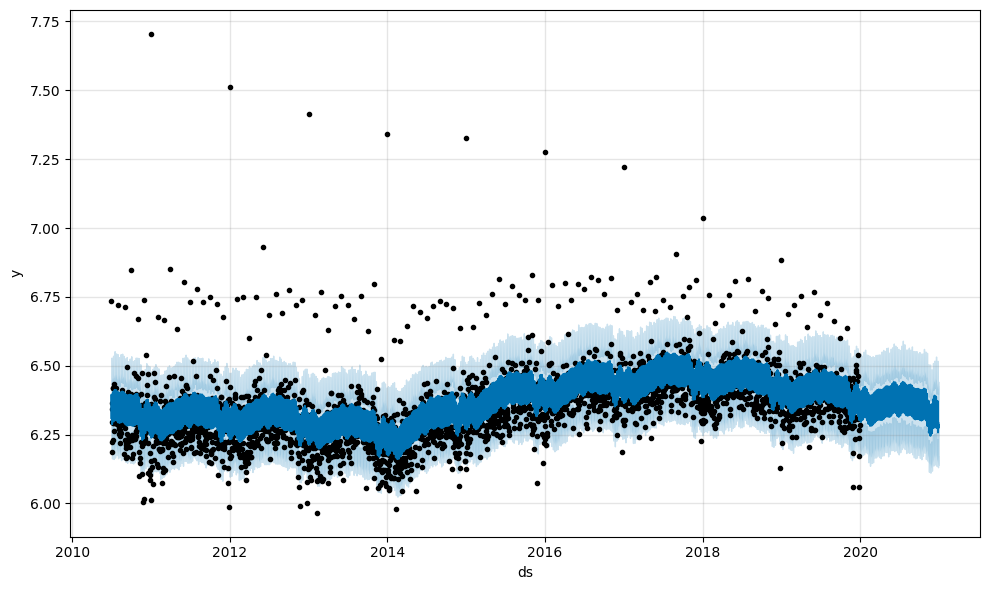

In [10]:
m1_plain.plot(forecast_m1)

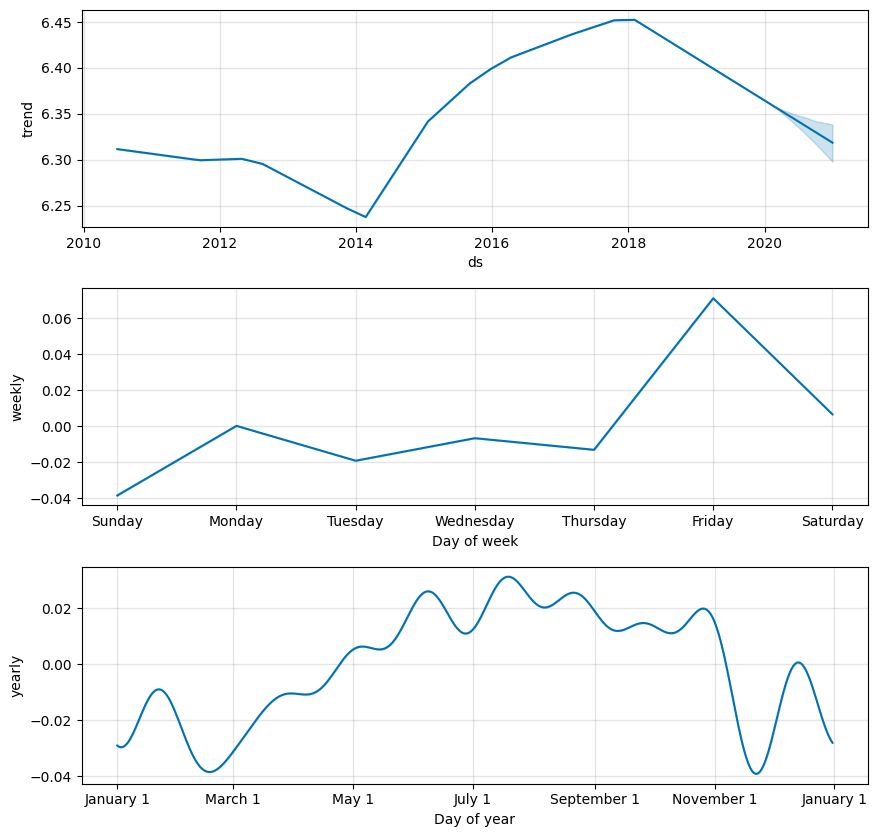

In [11]:
m1_plain.plot_components(forecast_m1)

In [12]:
y = df['y'].to_frame()
y.index = df['ds']
n = int(y.count())
forecast_m1_exp = np.exp(forecast_m1[['yhat','yhat_lower','yhat_upper']])
forecast_m1_exp.index = forecast_m1['ds']
error = forecast_m1_exp['yhat'] - y['y']
MAPE_m1 = (error/y['y']).abs().sum()/n *100
round(MAPE_m1,2)

5.94

In [13]:
df_m2 = df.copy()
ucl = df_m2.mean() + df_m2.std()*3
lcl = df_m2.mean() - df_m2.std()*3
print('Above 3 standard deviations: ', df_m2[df_m2['y'] > ucl['y']]['y'].count(), 'entries')
print('Below 3 standard deviations: ', df_m2[df_m2['y'] < lcl['y']]['y'].count(), 'entries')

Above 3 standard deviations:  52 entries
Below 3 standard deviations:  0 entries


C:\Users\owais\AppData\Local\Temp\ipykernel_2816\4010360867.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  ucl = df_m2.mean() + df_m2.std()*3
C:\Users\owais\AppData\Local\Temp\ipykernel_2816\4010360867.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  lcl = df_m2.mean() - df_m2.std()*3


In [14]:
df_m2.loc[df_m2['y'] > ucl['y'], 'y'] = None
df_m2.loc[df_m2['y'] < lcl['y'], 'y'] = None
df_m2['y'] = np.log(df_m2['y'])
m2_no_outlier = Prophet()
m2_no_outlier.fit(df_m2)
future = m2_no_outlier.make_future_dataframe(periods=365)
forecast_m2 = m2_no_outlier.predict(future)
forecast_m2_exp = np.exp(forecast_m2[['yhat','yhat_lower','yhat_upper']])
forecast_m2_exp.index = forecast_m2['ds']
error = forecast_m2_exp['yhat'] - y['y']
MAPE_m2 = (error/y['y']).abs().sum()/n *100
round(MAPE_m2,2)

20:55:00 - cmdstanpy - INFO - Chain [1] start processing
20:55:02 - cmdstanpy - INFO - Chain [1] done processing


5.8

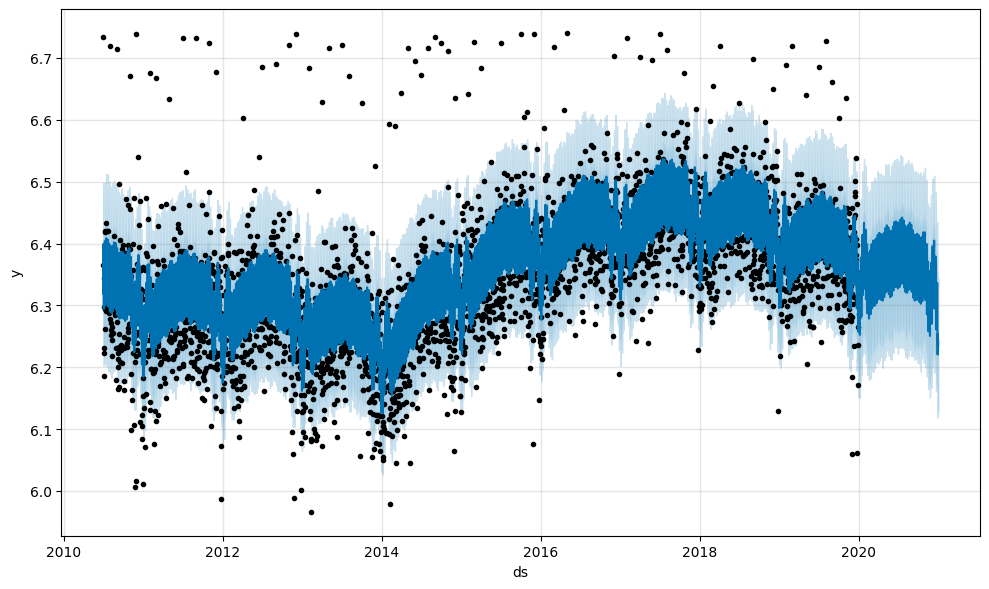

In [15]:
m2_no_outlier.plot(forecast_m2)

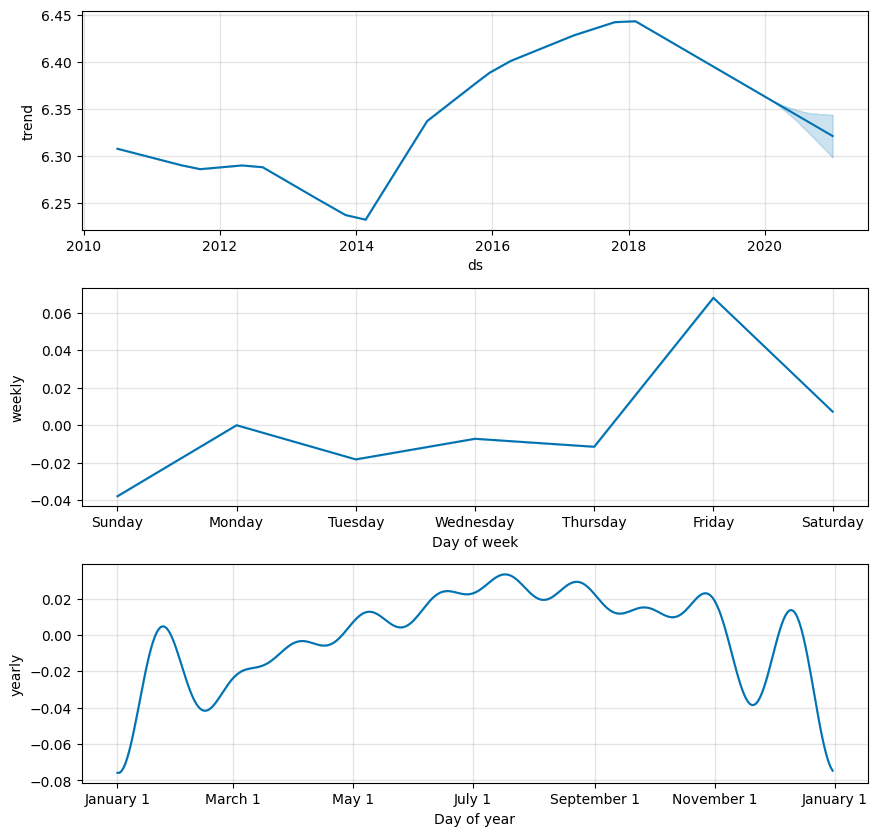

In [16]:
m2_no_outlier.plot_components(forecast_m2)